<h1 align='center'>DS200 - Lab6: Tweet Sentiment Classification with SVM</h1>


## Introduction:

In this lab we will perform some natural language processing tasks on our Twitter `#climatechange` dataset to evaluate user sentiment within the 280 character chunk of tweet text. 

We have pre-filtered the dataset to remove end-of-line characters, nonsensical characters, multiple sequential spaces, single character words, etc. 

In addition, we have used Textblob's built-in [sentiment function](https://planspace.org/20150607-textblob_sentiment/)  to generate the core of the dataset. This process consists of running the Textblob `polarity` and `subjectivity` sentiment analysis on the tweet text from our `#climatechange` dataset and generate the corresponding `Polarity Score` and `Subjectivity Score` as two separate features.

+ **Polarity Score**: How positive or negative a text is. `-1` is very negative. `+1` is very positive.
+ **Subjectivity Score**: How subjective, or opinionated a text is. `0` is fact. `+1` is very much an opinion.
   
## Lab goal:

Train an SVM classifier, so that given a tweet text, the model classifies the text into three possible sentiments: 
+ Negative
+ Neutral
+ Positive



## Section 1: Import Packages and Load the Data

#### Import necessary packages

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Load the `#climatechange` dataset from the given URL, and create a DataFrame named `climate`.

In [96]:
URL = 'https://raw.githubusercontent.com/BlueJayADAL/DS200/master/datasets/climate_change_corpus.csv'

In [97]:
climate = pd.read_csv(URL)



#### Show the information of the DataFrame

In [98]:
climate.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44127 entries, 0 to 44126
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   retweet_id    44127 non-null  object 
 1   tweet_text    44127 non-null  object 
 2   polarity      44127 non-null  float64
 3   subjectivity  44127 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.3+ MB


#### Display the top 5 records

In [99]:
climate.head()



,retweet_id,tweet_text,polarity,subjectivity
0,1068067040882233344,rt unfccc delegates from around the world are ...,0.000000,0.000000
1,1068210734977490944,rt saskboy think we most often hear the word d...,-0.066667,0.466667
2,1068223231264505857,rt ecosensenow it mat not be obvious but einst...,0.000000,0.500000
3,1068181567510626310,rt climatecomms most americans now see climate...,-0.277778,0.722222
4,1068187254768590848,rt portlandbem last week federal climate chang...,0.000000,0.322222


#### Print out the tweet texts from the top 2 records

In [100]:
print(climate['tweet_text'][0])
print(climate['tweet_text'][1])






rt unfccc delegates from around the world are coming to katowice poland to participate in the un climatechange convention cop24 
rt saskboy think we most often hear the word depravity when referring to careless driver who has killed someone through their reckl 


#### Study the basic statistics.

In [101]:
climate.describe()

,polarity,subjectivity
count,44127.000000,44127.000000
mean,0.084848,0.312869
std,0.251816,0.316471
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.277273
75%,0.195644,0.525000
max,1.000000,1.000000


## Section 2: EDA

#### Plot the histograms for `polarity` and `subjectivity` within subplots. Ensure to include titles for the subplots. 

Text(0.5, 1.0, 'Subjectivity Histogram')

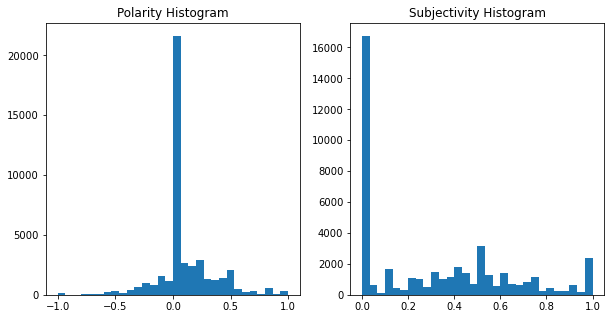

In [102]:
fig, axs = plt.subplots(nrows=1, ncols = 2, figsize = (10, 5))

axs[0].hist(x = climate['polarity'], bins=30)
axs[0].set_title('Polarity Histogram')
axs[1].hist(x = climate['subjectivity'], bins=30)
axs[1].set_title('Subjectivity Histogram')







#### Notice from the histograms that both `polarity` and `subjectivity` columns are numerical. For the classification purpose in this lab, we need to prepare the categorical label columns. Given the following criteria:

| Polarity Score Range | Meaning  | Label |
|----------------------|----------|-------|
| (0.6, 1]             | Positive | 1     |
| [-0.2, 0.6]          | Neutral  | 0     |
| [-1, -0.2)           | Negative | -1    |


| Subjectivity Score Range | Meaning    | Label |
|--------------------------|------------|-------|
| (0.8, 1]                 | Subjective | 1     |
| [0.02, 0.8]              | Neither    | 0     |
| [0, 0.02)                | Objective  | -1    |

#### Create two functions prototyped as below so that we can use them for label column generation.


In [103]:
def gen_polarity_label(polarity: float) -> int:
    '''
    Function takes a polarity number as the input,
    and generates a integer label
    '''
    if(polarity>0.6 and polarity<=1):
        return 1
    elif(polarity>=-0.2 and polarity<=0.6):
        return 0
    elif(polarity>=-1 and polarity< -0.2):
        return -1
    

In [104]:
def gen_subjectivity_label(subjectivity: float) -> int:
    '''
    Function takes a subjectivity number as the input,
    and generates a integer label
    '''
    if(subjectivity>0.8 and subjectivity<=1):
        return 1
    elif(subjectivity>=0.2 and subjectivity<=0.8):
        return 0
    elif(subjectivity>=0 and subjectivity< 0.2):
        return -1

#### Create two columns for the DataFrame: `polarity_label` and `subjectivity_label`.

In [105]:
climate['polarity_label'] = climate['polarity'].apply(gen_polarity_label)



In [106]:
climate['subjectivity_label'] = climate['subjectivity'].apply(gen_subjectivity_label)



#### Visualize the counts for the categories from `polarity_label` and `subjectivity_label` columns.

<AxesSubplot:xlabel='polarity_label', ylabel='count'>

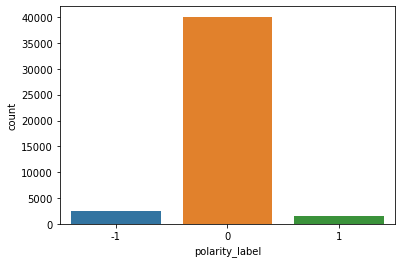

In [107]:
sns.countplot(data=climate, x='polarity_label')



<AxesSubplot:xlabel='subjectivity_label', ylabel='count'>

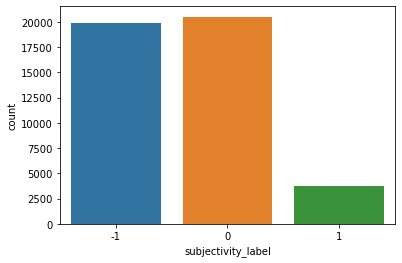

In [108]:
sns.countplot(data=climate, x='subjectivity_label')



## Section 3: Data Transformation and Preparation

#### Filter out three subsets from the `climate` DataFrame for each kind of `polarity_label`.

In [109]:
# The negative subset
climate_neg = climate[climate['polarity_label']==-1]

# The neutral subset
climate_ntr = climate[climate['polarity_label']==0]

# The positive subset
climate_pos = climate[climate['polarity_label']==1]


#### Use the `.sample()` method on each subset to either up-sample or down-sample it. Ensure to set argument `n = 5000` so that each subset will get 5,000 samples. Set `replace=True` when up-sampling, and `replace=False` when down-sampling. Use random seed as 101. 

In [110]:
# Up-sample the negative subset
climate_neg = climate_neg.sample(n=5000, replace=True, random_state=101)

# Down-sample the neutral subset
climate_ntr = climate_ntr.sample(n=5000, replace=False, random_state=101)

# Up-sample the positive subset
climate_pos = climate_pos.sample(n=5000, replace=True, random_state=101)



#### Put together the three subsets to create a balanced dataset. 

In [111]:
# Put them together
climate_balanced = pd.concat([climate_neg, climate_ntr, climate_pos])


# Show the value counts
climate_balanced['polarity_label'].value_counts()

-1    5000
 0    5000
 1    5000
Name: polarity_label, dtype: int64

#### Generate the Document Term Matrix (DTM):

Now that we have balanced our datasets we can proceed to convert the tweet corpus into a word vector, also known as the Document Term Matrix (DTM).

To do that, we need to initialize a CountVectorizer. This transformer converts the tweet texts into a word vector, in which each word becomes a 'component' of the vector and has a specific magnitude. The magnitude in our case is the occurrences to that particular word within the text. We will also perform some simple preprocessing on the DTM such as removing stop words (e.g., "I", "am", "okay", "ah", "eh"...), and setting the max number of words as 85.


In [112]:
# Run this cell to have the Count Vectorizer

from sklearn.feature_extraction.text import CountVectorizer     
from sklearn.feature_extraction import text 

# Create a list of stop words
final_stop_words = text.ENGLISH_STOP_WORDS.union(['rt', 
                                                  'cop24', 
                                                  'realdonaldtrump', 
                                                  'says', 
                                                  've', 
                                                  'want',
                                                  'today',
                                                  'years'])

vectorizer = CountVectorizer(
    stop_words=final_stop_words,  # Removes the customized stop words
    analyzer = 'word',            # Use word n-gram
    max_features = 85             # Total number of words set to 85
)

Use the balanced DataFrame to train the vectorizer, then transform the DataFrame into a word vector. 

In [113]:
# Train the vectorizer, then obtain the features

features = vectorizer.fit_transform(climate_balanced['tweet_text']).toarray()

features.shape

(15000, 85)

In [114]:
# We can also obtain the 85 words from the trained vectorier

columns = vectorizer.get_feature_names()
columns

['act',
 'action',
 'address',
 'amazing',
 'amp',
 'arctic',
 'attenborough',
 'auspol',
 'australia',
 'awesome',
 'bad',
 'beautiful',
 'believe',
 'best',
 'carbon',
 'change',
 'children',
 'climate',
 'climateaction',
 'climatechange',
 'coal',
 'cold',
 'david',
 'day',
 'devastating',
 'don',
 'earth',
 'economy',
 'effects',
 'emissions',
 'energy',
 'environment',
 'excellent',
 'fight',
 'global',
 'globalwarming',
 'going',
 'good',
 'government',
 'great',
 'greatest',
 'happy',
 'hard',
 'health',
 'help',
 'https',
 'impact',
 'impacts',
 'just',
 'kids',
 'know',
 'let',
 'like',
 'make',
 'national',
 'need',
 'new',
 'news',
 'past',
 'people',
 'planet',
 'proud',
 'read',
 'record',
 'report',
 'science',
 'scientists',
 'sir',
 'stop',
 'stupid',
 'support',
 'talk',
 'thank',
 'think',
 'threat',
 'time',
 'trump',
 'uk',
 'warming',
 'way',
 'weather',
 'work',
 'world',
 'worst',
 'year']

#### Now, create the DTM in a Pandas DataFrame format. Name the DataFrame as `climate_dtm`. Ensure to create a label column `polarity_label` with the data from the `climate_balanced` DataFrame. 

In [115]:
climate_balanced.reset_index(drop=True,inplace=True)

In [116]:
climate_balanced['polarity_label']

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
14995    1
14996    1
14997    1
14998    1
14999    1
Name: polarity_label, Length: 15000, dtype: int64

In [117]:
climate_dtm = pd.DataFrame(data=features, columns=columns)
climate_dtm['polarity_label'] = climate_balanced['polarity_label']



# Show the new DataFrame. Scroll to right to find the label column. 
climate_dtm.head()

,act,action,address,amazing,amp,arctic,attenborough,auspol,australia,awesome,...,trump,uk,warming,way,weather,work,world,worst,year,polarity_label
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,-1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,-1


#### Prepare the X feature matrix and the y label vector

In [118]:
new_features = ['act', 'action', 'address', 'amazing', 'amp', 'arctic',
       'attenborough', 'auspol', 'australia', 'awesome', 'bad',
       'beautiful', 'believe', 'best', 'carbon', 'change', 'children',
       'climate', 'climateaction', 'climatechange', 'coal', 'cold',
       'david', 'day', 'devastating', 'don', 'earth', 'economy',
       'effects', 'emissions', 'energy', 'environment', 'excellent',
       'fight', 'global', 'globalwarming', 'going', 'good', 'government',
       'great', 'greatest', 'happy', 'hard', 'health', 'help', 'https',
       'impact', 'impacts', 'just', 'kids', 'know', 'let', 'like', 'make',
       'national', 'need', 'new', 'news', 'past', 'people', 'planet',
       'proud', 'read', 'record', 'report', 'science', 'scientists',
       'sir', 'stop', 'stupid', 'support', 'talk', 'thank', 'think',
       'threat', 'time', 'trump', 'uk', 'warming', 'way', 'weather',
       'work', 'world', 'worst', 'year']

In [119]:
X = climate_dtm[new_features]


y = climate_dtm['polarity_label']



#### As a final step for data preparation, we'll split the data into the training set and testing set. Use the test size as 20%, and set the random seed as 101.

In [120]:
from sklearn.model_selection import train_test_split

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=101)






# Verify the sizes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12000, 85)
(3000, 85)
(12000,)
(3000,)


In [122]:
# Find the value count to labels
y_train.value_counts()

 1    4012
-1    3995
 0    3993
Name: polarity_label, dtype: int64

## Section 4: Data Modeling and Evaluation

Having preprocessed the data, now we can build a classifier! We'll be trying two different classifiers: 1) Logistic Regression; and 2) Support Vector Classifier.  

#### Train a logistic regression model with `liblinear` solver, and random seed as 101. Then evaluate the result using confusion matrix and classification report. 

In [123]:
from sklearn.linear_model import LogisticRegression

In [124]:
logmodel = LogisticRegression(solver='liblinear', random_state=101)


logmodel.fit(X_train, y_train)

LogisticRegression(random_state=101, solver='liblinear')

In [125]:
logpredictions = logmodel.predict(X_test)

In [126]:
from sklearn.metrics import classification_report, confusion_matrix

In [127]:
print(confusion_matrix(y_test, logpredictions))
print(classification_report(y_test, logpredictions))

[[513 486   6]
 [205 767  35]
 [ 39 193 756]]
              precision    recall  f1-score   support

          -1       0.68      0.51      0.58      1005
           0       0.53      0.76      0.63      1007
           1       0.95      0.77      0.85       988

    accuracy                           0.68      3000
   macro avg       0.72      0.68      0.68      3000
weighted avg       0.72      0.68      0.68      3000



#### Train a SVC model with random seed as 101. Then evaluate the result using confusion matrix and classification report. 

In [128]:
from sklearn.svm import SVC

In [129]:
# Fit the SVM model
model = SVC(random_state=101)

model.fit(X_train, y_train)



SVC(random_state=101)

In [130]:
predictions = model.predict(X_test)



In [131]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[562 440   3]
 [168 813  26]
 [ 16 190 782]]
              precision    recall  f1-score   support

          -1       0.75      0.56      0.64      1005
           0       0.56      0.81      0.66      1007
           1       0.96      0.79      0.87       988

    accuracy                           0.72      3000
   macro avg       0.76      0.72      0.72      3000
weighted avg       0.76      0.72      0.72      3000



## Section 5: Hyper-parameter Tuning

Use the following setting for the parameter grid.
```
C = [10, 1, 0.1], 
gamma = [10, 1, 0.1], 
kernel = ['rbf']
```

In [132]:
# Create the parameter grid dictionary
param_grid = {'C' : [10, 1, 0.1], 'gamma' : [10, 1, 0.1], 'kernel' : ['rbf']}

#### Create a grid of estimators with `SVC()`, and train them with the training set. Set `cv=3` and `verbose=3`.

In [133]:
from sklearn.model_selection import GridSearchCV

In [134]:
grid = GridSearchCV(estimator=SVC(random_state=101),
                    param_grid=param_grid,
                    n_jobs=4,
                    cv=3,
                    verbose=3)


In [135]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=SVC(random_state=101), n_jobs=4,
             param_grid={'C': [10, 1, 0.1], 'gamma': [10, 1, 0.1],
                         'kernel': ['rbf']},
             verbose=3)

#### Print the best parameters and best model.

In [136]:
grid.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [137]:
grid.best_estimator_

SVC(C=1, gamma=1, random_state=101)

#### Make a prediction with the best model and evaluate the result using confusion matrix and classification report. 

In [138]:
grid_predictions = grid.predict(X_test)

In [139]:
print(confusion_matrix(y_test, grid_predictions))
print(classification_report(y_test, grid_predictions))

[[618 373  14]
 [161 824  22]
 [ 25 154 809]]
              precision    recall  f1-score   support

          -1       0.77      0.61      0.68      1005
           0       0.61      0.82      0.70      1007
           1       0.96      0.82      0.88       988

    accuracy                           0.75      3000
   macro avg       0.78      0.75      0.75      3000
weighted avg       0.78      0.75      0.75      3000



# Great Job!